# **Μερική Διαφορική Εξίσωση Korteweg - de Vries (KdV) (1895)**

### *Γενική μορφή της ΜΔΕ KdV:*

$$
u_t + auu_x + bu_{xxx} = 0
$$

---

### *Τα σύμβολα:*
$$u(x,t)=u \text{: ύψος κύματος}$$
$$u_t \text{: ταχύτητα αλλαγής}$$
$$u_x \text{: κλίση του κύματος}$$
$$u_{xxx} \text{: διασπορά}$$
$$a \text{: συντελεστής μη γραμμικότητας}$$
$$b \text{: συντελεστής διασποράς}$$

---

### **Προσεγγίζουμε την κλασική ΜΔΕ KdV:**

$$
u_t + auu_x + bu_{xxx} = 0
$$

**με**

$$a=p=6$$
$$b=q=1$$

$$x \in [-L,L]=[-12,12]$$

$$t \in [0,T]=[0,5]$$

---

### **Αρχική συνθήκη:**

$$
u(x,0) = \frac{c}{2} \, \text{sech}^2 \Big( \frac{\sqrt{c}}{2} x \Big)
$$

**με**

$$c=1$$

---

### **Συνοριακές συνθήκες: (Περιοδικές)**

$$ u(-L,t)= u(L,t) $$
$$ u_x(-L,t)= u_x(L,t) $$
$$ u_{xx}(-L,t)= u_{xx}(L,t) $$


In [ ]:
import torch #βασικό πακέτο PyTorch
import torch.nn as nn #έτοιμες συναρτήσεις για νν
import torch.nn.functional as f #συναρτήσεις ενεργοποίησης
import torch.optim as optim #βελτιστοποιητές
import numpy as np #βιβλιοθήκη αριθμητικών υπολογισμών
from time import time #μέτρηση χρόνου
import gc #για καθαρισμό cpu
import platform #για το τι συσκευή cpu χρησιμοποιώ


use_cuda = input("Να κεράσω CUDA; (ναι/οχι): ").strip().lower()

if use_cuda == "ναι":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

print("Χρήση συσκευής:", device)
print(torch.__version__)

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print("Κερασμένη η CUDA!")
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  torch.cuda.empty_cache() # άδειασμα gpu
else:
  print("Μας τελείωσε η CUDA...")
  print(platform.uname())
  gc.collect() # άδειασμα cpu

#Ζέσταμα GPU για να μην πετάει warning
if device.type == "cuda":
    torch.cuda.init()
    torch.cuda.empty_cache()
    torch.randn(8, 8, device=device) #warm-up cuBLAS

Να κεράσω CUDA; (ναι/οχι): οχι
Χρήση συσκευής: cpu
2.9.0+cpu
False
Μας τελείωσε η CUDA...
uname_result(system='Linux', node='1394e36db107', release='6.6.105+', version='#1 SMP Thu Oct  2 10:42:05 UTC 2025', machine='x86_64')


In [ ]:
#ορισμός ακρίβειας
dtype = torch.float32

#Σταθερές
pi = torch.tensor(np.pi, dtype=dtype, device=device) #π
a = torch.tensor(6, dtype=dtype, device=device) #συντελεστής μη γραμμικότητας
b = torch.tensor(1, dtype=dtype, device=device) #συντελεστής διασποράς
c = torch.tensor(1, dtype=dtype, device=device) #ταχύτητα σολιτονίου (κύματος)
L = 24 #πλάτος χώρου
L_min = torch.tensor(-L/2, dtype=dtype, device=device) #πλάτος χώρου ελάχιστο
L_max = torch.tensor(L/2, dtype=dtype, device=device) #πλάτος χώρου μεγιστο
T_max = torch.tensor(5, dtype=dtype, device=device) #χρόνος

#Αρχική Συνθήκη
def fun_u_0(t,x):
    #return torch.sin(pi*x)
    return (c/2) * 1.0 / torch.cosh( (torch.sqrt(c)/2 * x ) ) **2

#Συνοριακές Συνθήκες
def fun_u_b_left(t,x):
    #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
    #Ενσωματώνονται στο training loop και loss
    return None

def fun_u_b_right(t,x):
    #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
    #Ενσωματώνονται στο training loop και loss
    return None

def fun_u_b_xr(t,x):
    #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
    #Ενσωματώνονται στο training loop και loss
    return None

#ΜΔΕ Εξίσωση KdV
def fun_r(u, u_t, u_x, u_xxx):
    return u_t + a * u * u_x + b * u_xxx

In [ ]:
#Αριθμός σημείων
N_0 = 50 #πλήθος αρχικής συνθήκες u(x,0)
N_b = 100 #πλήθος συνοριακών συνθηκών u(±L, t)
N_r = 500 #πλήθος στο εσωτερικό του πεδίου εκπαίδευσης της ΜΔΕ

#Συνοριακές τιμές
tmin = torch.tensor(0, dtype=dtype, device=device)
tmax = T_max
xmin = L_min
xmax = L_max

In [ ]:
print(f'Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:\n')
print(f'[tmin,tmax] x [xmin,xmax]')
print(f'[{tmin}, {tmax.item()}] x [{xmin.item()}, {xmax.item()}]\n')


Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:

[tmin,tmax] x [xmin,xmax]
[0.0, 5.0] x [-12.0, 12.0]



In [ ]:
#Κάτω όριο
lb = torch.tensor([tmin, xmin], dtype=dtype, device=device)
#Πάνω όριο
ub = torch.tensor([tmax, xmax], dtype=dtype, device=device)

In [ ]:
print(f'lb:', lb.device)
print(f'ub:', ub.device)

lb: cpu
ub: cpu


In [ ]:
#Σταθεροποίηση γεννήτριας τυχαίων αριθμών
torch.manual_seed(67)

In [ ]:
#Δημιουργία σημείων αρχικών συνθηκών


#στήλη με την αρχική τιμή του χρόνου
###t_0 = torch.ones((N_0,1), dtype=dtype, requires_grad=True, device=device)*lb[0]
t_0 = torch.ones((N_0,1), dtype=dtype, device=device)*lb[0]

#στήλη με τυχαίους στο διάστημα [xmin,xmax]
###x_0 = torch.rand((N_0,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]
x_0 = torch.rand((N_0,1), dtype=dtype, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σε tensor (N0,2) ##δύο στήλες t0,x0
X_0 = torch.concat([t_0, x_0], dim=1)

In [ ]:
print(f't_0: ',t_0.shape)
print(f'x_0: ',x_0.shape)
print(f'X_0: ',X_0.shape)
print(f't_0: ',t_0.device)
print(f'x_0: ',x_0.device)
print(f'X_0: ',X_0.device)

t_0:  torch.Size([50, 1])
x_0:  torch.Size([50, 1])
X_0:  torch.Size([50, 2])
t_0:  cpu
x_0:  cpu
X_0:  cpu


In [ ]:
#Υπολογισμός αρχικής συνθήκης
u_0 = fun_u_0(t_0, x_0)

In [ ]:
print(f'u_0: ',u_0.shape)
print(f'u_0: ',u_0.device)

u_0:  torch.Size([50, 1])
u_0:  cpu


In [ ]:
# Δημιουργία σημείων συνοριακών συνθηκών


#στήλη με τυχαίους στο διάστημα [tmin, tmax]
t_b = torch.rand((N_b,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#στήλη με N_b στοιχεία για το xmin σύνορο (αριστερά)
x_b_left = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*lb[1]

#στήλη με N_b στοιχεία για το xmax σύνορο (δεξιά)
x_b_right = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*ub[1]

#Συνδιασμός σε tensor (N_b,3)
X_b = torch.concat([t_b, x_b_left, x_b_right], dim=1)

In [ ]:
print(f't_b:       ',t_b.shape)
print(f'x_b_left:  ',x_b_left.shape)
print(f'x_b_right: ',x_b_right.shape)
print(f'X_b:       ',X_b.shape)
print(f't_b:       ',t_b.device)
print(f'x_b_left:  ',x_b_left.device)
print(f'x_b_right: ',x_b_right.device)
print(f'X_b:       ',X_b.device)

t_b:        torch.Size([100, 1])
x_b_left:   torch.Size([100, 1])
x_b_right:  torch.Size([100, 1])
X_b:        torch.Size([100, 3])
t_b:        cpu
x_b_left:   cpu
x_b_right:  cpu
X_b:        cpu


In [ ]:
#Υπολογισμός Συνοριακών Συνθηκών

#Αυτό το κομμάτι κώδικα στις περιοδικές δεν χρειάζεται.
#Δεν έχουμε να υπολογίσουμε κάτι, θέλουμε απλά να είναι ίσες.

In [ ]:
#Τυχαία σημεία λύσης

#Δημιουργία τυχαίων τιμών στο χρόνο [tmin, tmax]
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#Δημιουργία τυχαίων τιμών στο χώρο [xmin, xmax]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σημείων σε tensor (N_r,2)
X_r = torch.concat([t_r, x_r], dim=1)

In [ ]:
print(f't_r: ',t_r.shape)
print(f'x_r: ',x_r.shape)
print(f'X_r: ',X_r.shape)
print(f't_r: ',t_r.device)
print(f'x_r: ',x_r.device)
print(f'X_r: ',X_r.device)

t_r:  torch.Size([500, 1])
x_r:  torch.Size([500, 1])
X_r:  torch.Size([500, 2])
t_r:  cpu
x_r:  cpu
X_r:  cpu


In [ ]:
#λίστες

#(Ν_0,2) αρχικά σημεία, (Ν_b,3) συνοριακά σημεία
X_data = [X_0, X_b]

#(Ν_0,1) αρχικές τιμές
u_data = [u_0]

In [ ]:
print(f'X_data[0]==X_0: ',X_data[0].shape)
print(f'X_data[1]==X_b: ',X_data[1].shape)
print(f'u_data[0]==u_0: ',u_data[0].shape)
print(f'X_data[0]==X_0: ',X_data[0].device)
print(f'X_data[1]==X_b: ',X_data[1].device)
print(f'u_data[0]==u_0: ',u_data[0].device)

X_data[0]==X_0:  torch.Size([50, 2])
X_data[1]==X_b:  torch.Size([100, 3])
u_data[0]==u_0:  torch.Size([50, 1])
X_data[0]==X_0:  cpu
X_data[1]==X_b:  cpu
u_data[0]==u_0:  cpu


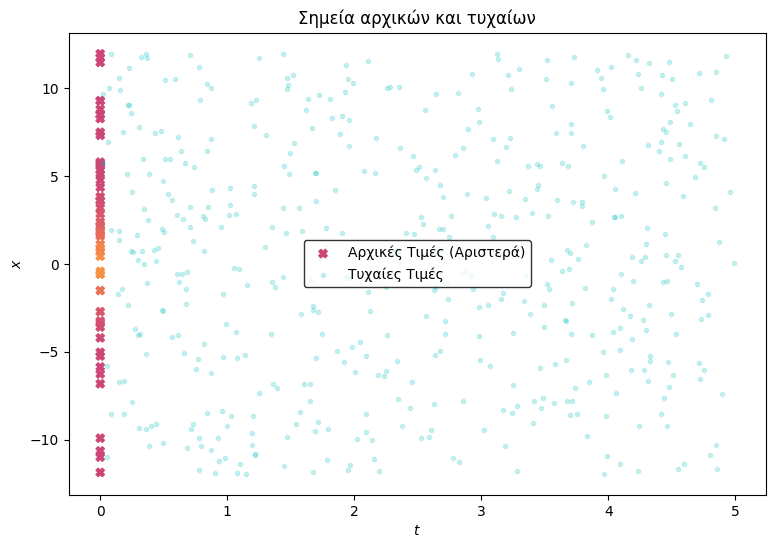

In [ ]:
import matplotlib.pyplot as plt #βιβλιοθήκη γραφήματα

fig = plt.figure(figsize=(9,6)) #καμβάς 9x6 ίντσες
color = 'plasma' #επιλογή χρώματος γραφίματος


#σημεία αρχικής συνθήκης
plt.scatter(t_0.cpu().detach(), x_0.cpu().detach(), c=u_0.cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Αρχικές Τιμές (Αριστερά)')

#σημεία τυχαία
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(loc='center').get_frame().set_edgecolor('black')
plt.title('Σημεία αρχικών και τυχαίων');

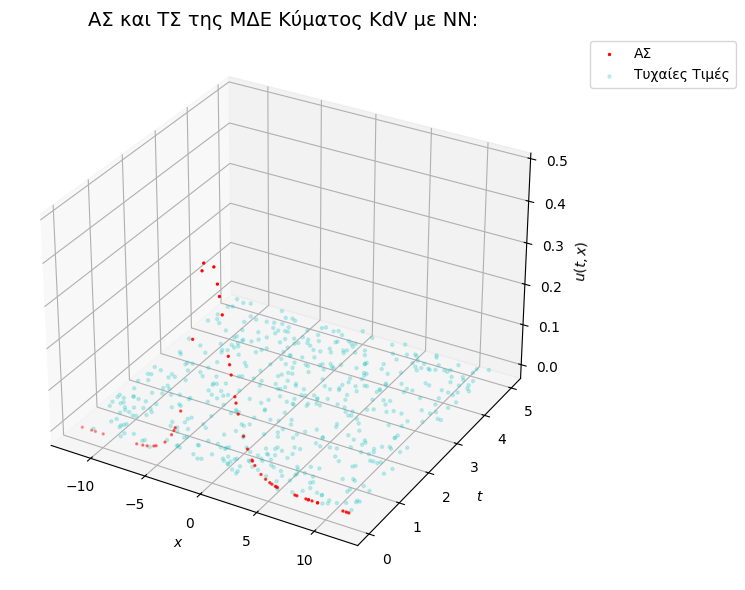

Στο t=Τ έχουμε min U_0 = 0.000, max U_0 = 0.478


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u_0.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#σημεία τυχαία
ax.scatter(x_r.cpu().detach(), t_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και TΣ της ΜΔΕ Κύματος KdV με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u_0.min().item()
U0_max = u_0.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

In [ ]:
#Δημιουργία ΝΝ

class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        #Το input layer συνδέεται στο 1ο layer (με 20 νευρώνες)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        #Τα layers από το 1ο μέχρι το 8ο
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        #Το output layer δίνει πραγματική τιμή
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        #Αρχικοποίηση βαρών
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            #αποτρέπει τα πολύ μεγάλα και πολύ μικρά βάρη
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        # Μετασχηματιμσός του x για να βρίσκεται στο [lb[1], ub[1]]=[xmin,xmax]=[-1,1] για ταχύτερη επκπαίδευση με την tanh
        x = 2.0*(x - lb)/(ub - lb) - 1.0

        #Το input layer
        x = torch.tanh(self.input_layer(x))
        #1ο με 8ο hidden layer
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        #Το output layer
        x = self.output_layer(x)
        return x

In [ ]:
#Υπολογισμός Απώλειας

#Μέσο Τετραγωνικό Σφάλμα
mse_loss = nn.MSELoss()

def compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag):

    ##Απώλεια ΜΔΕ
    #Σπάσιμο στηλών t,x για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    t = X_r[:,0:1]#.detach().requires_grad_(True)
    x = X_r[:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση ΜΔΕ μοντέλου
    u = model(torch.concat([t,x],dim=1))

    #Υπολογισμός Μερικών Παραγώγων
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]

    #Υπολογισμός της απώλειας της ΜΔΕ
    l_u = torch.mean(torch.square(fun_r(u, u_t, u_x, u_xxx)))


    ##Απώλεια αρχικής συνθήκης
    #Σπάσιμο στηλών t0,x0
    t0 = X_data[0][:,0:1]#.clone().detach().requires_grad_(True)
    x0 = X_data[0][:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση αρχικής τιμής μοντέλου
    u0 = model(torch.concat([t0,x0],dim=1))

    #Υπολογισμός της απώλειας της αρχικής συνθήκης
    l_0 = torch.mean(torch.square(u_data[0]-u0))


    ##Απώλεια συνοριακών τιμών (Περιοδικές)
    #Σπάσιμο στηλών t,x για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    tb = X_data[1][:,0:1]#.clone().detach().requires_grad_(True)
    xbl = X_data[1][:,1:2]#.detach().requires_grad_(True)
    xbr = X_data[1][:,2:3]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου Αριστερά
    ubl = model(torch.concat([tb, xbl],dim=1))
    ubl_x = torch.autograd.grad(ubl, xbl, torch.ones_like(ubl), create_graph=True)[0]
    ubl_xx = torch.autograd.grad(ubl_x, xbl, torch.ones_like(ubl), create_graph=True)[0]
    #ubl_xxx = torch.autograd.grad(ubl_xx, xbl, torch.ones_like(ubl), create_graph=True)[0]

    #Εκτίμηση μοντέλου Δεξιά
    ubr = model(torch.concat([tb, xbr],dim=1))
    ubr_x = torch.autograd.grad(ubr, xbr, torch.ones_like(ubr), create_graph=True)[0]
    ubr_xx = torch.autograd.grad(ubr_x, xbr, torch.ones_like(ubr), create_graph=True)[0]
    #ubr_xxx = torch.autograd.grad(ubr_xx, xbr, torch.ones_like(ubr), create_graph=True)[0]

    #Υπολογισμός απώλειας συνοριακών συνθηκών
    l_lr = mse_loss(ubl, ubr)
    l_lr_x = mse_loss(ubl_x, ubr_x)
    l_lr_xx = mse_loss(ubl_xx, ubr_xx)
    #l_lr_xxx = mse_loss(ubl_xxx, ubr_xxx)

    l_b = l_lr + l_lr_x + l_lr_xx #+ l_lr_xxx

    #Προσαρμογή Βαρών κάθε loss
    w_u = 1
    w_b = 1
    w_0 = 1

    #Συνολική απώλεια
    loss = w_u * l_u + w_b * l_b + w_0 * l_0

    if (epochs % 100 == 0) and (verbose_flag != -1):
      print(f'Epoch {epochs:05d}: l_u = {l_u:10.8e}, l_b = {l_b:10.8e}, l_0 = {l_0:10.8e}, loss = {loss:10.8e}')

    return loss

In [ ]:
model = NeuralNetwork().to(device)

# Έλεγχος ότι το μοντέλο πήγε στη GPU
print("Model is on:", next(model.parameters()).device)

#Σταθερά learning rate
lr_schedule = [5e-4, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 100:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

#Adam βελτιστοποιητής
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

Model is on: cpu


In [ ]:
#Αριθμός εποχών
epochs=0
epoch = 2000
#Λίστα απώλειας κάθε εποχής
losses = []
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

for i in range(epoch):

    #Ενημέρωση της σταθεράς learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    #Μηδενισμός των παραγώγων του βελτιστοποιητή πριν το backpropagation
    optimizer.zero_grad()

    #Υπολογισμός σφάλματος
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=1)

    #Έλεγχος ποιες παράμετροι δεν είναι CUDA
    #for name, param in model.named_parameters():
        #if param.device.type != 'cuda':
            #print("Parameter on CPU:", name, param.device)

    #Υπολογισμός των παραγώγων τρέχουσας εποχής
    loss.backward(retain_graph=True)

    #Ενημέρωση βαρών επόμενης εποχής
    optimizer.step()

    #Αποθήκευση του σφάλματος κάθε εποχής
    losses.append(loss.item())

    #Για την εκτύπωση του loss
    epochs = epochs + 1

    #Εφαρμογή του early stopping
    if loss.item() < 1e-5:
       break

#Εμφάνιση χρόνου εκτέλεσης του μοντέλου
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Εκπαίδευσης Μοντέλου: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')
print(f'\nEpochs: {epochs}, loss = {losses[epochs-1]:10.8e}')

Epoch 00000: l_u = 1.76528454e-04, l_b = 2.88008689e-03, l_0 = 2.76690274e-02, loss = 3.07256430e-02
Epoch 00100: l_u = 3.05880792e-04, l_b = 5.50341967e-04, l_0 = 1.14672044e-02, loss = 1.23234270e-02
Epoch 00200: l_u = 3.75827891e-04, l_b = 1.78636794e-04, l_0 = 7.33729824e-03, loss = 7.89176300e-03
Epoch 00300: l_u = 4.21255565e-04, l_b = 3.10545693e-05, l_0 = 2.03277287e-03, loss = 2.48508295e-03
Epoch 00400: l_u = 2.60764238e-04, l_b = 7.70354654e-06, l_0 = 1.86924604e-04, loss = 4.55392408e-04
Epoch 00500: l_u = 2.02341107e-04, l_b = 7.95009328e-06, l_0 = 1.67392354e-05, loss = 2.27030425e-04
Epoch 00600: l_u = 1.57259259e-04, l_b = 6.62384900e-06, l_0 = 6.74920602e-06, loss = 1.70632309e-04
Epoch 00700: l_u = 1.23230522e-04, l_b = 5.35175423e-06, l_0 = 4.72910460e-06, loss = 1.33311391e-04
Epoch 00800: l_u = 9.75215735e-05, l_b = 4.43393947e-06, l_0 = 3.65349047e-06, loss = 1.05609004e-04
Epoch 00900: l_u = 7.78688918e-05, l_b = 3.77948982e-06, l_0 = 2.96319081e-06, loss = 8.461

In [ ]:
# Fine-tuning με L-BFGS
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()
lbfgs_counter = 0  #μετρητής βημάτων LBFGS

optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),    #μεταβολή των βαρών του μοντέλου
                                    max_iter=500,          #μέγιστος αριθμός εσωτερικών βημάτων
                                    tolerance_grad=1e-7,   #έξοδος όταν η μέση κλίση είναι μικρότερη από
                                    tolerance_change=1e-9, #έξοδος όταν τα βάρη είναι μικρότερα από
                                    history_size=50,       #πόσα προηγούμενα βήματα να θυμάται για την εκτίμηση της Hessian
                                    line_search_fn="strong_wolfe") #για σταθερή σύγκλιση, αποφυγεί πολύ μικρών/μεγάλων βημάτων

def closure():
    optimizer_lbfgs.zero_grad() #μηδενισμός προηγούμενων gradients
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=-1) #υπολογισμός απώλειας
    loss.backward(retain_graph=True) #υπολογισμός gradients
    global lbfgs_counter #για να την πάρει από έξω
    lbfgs_counter = lbfgs_counter + 1 #μετρητής βημάτων LBFGS
    return loss

#Μία κλήση LBFGS (κάνει εσωτερικά 500 αλληλεπιδράσεις)
optimizer_lbfgs.step(closure)

#Τελική αξιολόγηση μετά το LBFGS
loss_lbfgs = compute_loss(model, X_r, X_data, u_data, 0, verbose_flag=-1)

print(f"LBFGS Επανάληψη {lbfgs_counter}")
print(f"LBFGS Σφάλμα {loss_lbfgs.item():10.8e}")
print(f"LBFGS βελτίωση: Από {losses[-1]:10.8e} σε {loss_lbfgs.item():10.8e}")
print(f"Διαφορά LBFGS με Adam: {(loss_lbfgs.item() - losses[-1]):+10.8e}")


#Εμφάνιση χρόνου εκτέλεσης του LBFGS
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Βελτιστοποίησης με LBFGS: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')

LBFGS Επανάληψη 3
LBFGS Σφάλμα 1.26990117e-05
LBFGS βελτίωση: Από 1.27365456e-05 σε 1.26990117e-05
Διαφορά LBFGS με Adam: -3.75339368e-08

Χρόνος Βελτιστοποίησης με LBFGS: 0 μέρες, 0 ώρες, 0 λεπτά, 0 δευτερόλεπτα


In [ ]:
input(f"Να συνεχίσω το προγραμμα' ; (ναι/οχι): ").strip().lower()

Να συνεχίσω το προγραμμα' ; (ναι/οχι): οχι


'οχι'

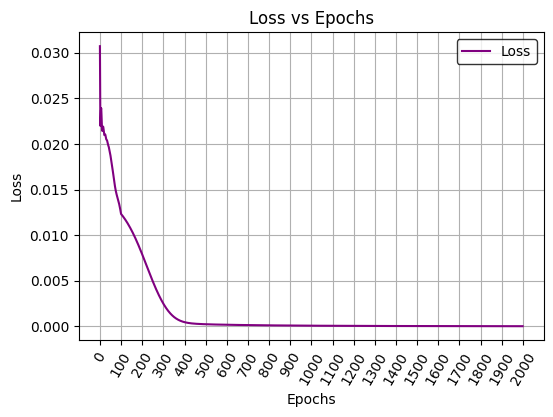

In [ ]:
#Απώλεια κάθε εποχής
fig = plt.figure(figsize=(6,4))

plt.plot(range(epochs), losses, label='Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(loc='upper right').get_frame().set_edgecolor('black')
plt.xticks(range(0, epoch+1, 100), rotation=60)
plt.grid(True)
plt.show()

u0_m:  torch.Size([50, 1])
ubl_m:  torch.Size([100, 1])
ubr_m:  torch.Size([100, 1])


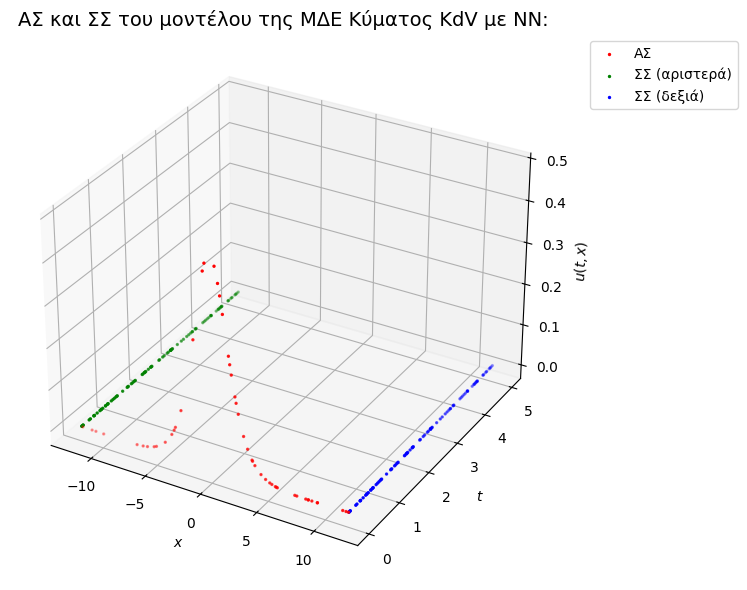

Στο t=Τ έχουμε min U_0 = 0.000, max U_0 = 0.477


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Τελική εκτίμηση μοντέλου Αρχικής Συνθήκης
u0_m = model(torch.concat([t_0, x_0],dim=1))
print(f'u0_m: ',u0_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Αριστερά
ubl_m = model(torch.concat([t_b, x_b_left],dim=1))
print(f'ubl_m: ',ubl_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Δεξιά
ubr_m = model(torch.concat([t_b, x_b_right],dim=1))
print(f'ubr_m: ',ubr_m.shape)

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u0_m.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#Συνοριακή Συνθήκη (Αριστερά)
ax.scatter(x_b_left.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubl_m.detach().cpu().numpy(), color='g', label='ΣΣ (αριστερά)', s=2);

#Συνοριακή Συνθήκη (Δεξιά)
ax.scatter(x_b_right.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubr_m.detach().cpu().numpy(), color='b', label='ΣΣ (δεξιά)', s=2);


ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και ΣΣ του μοντέλου της ΜΔΕ Κύματος KdV με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u0_m.min().item()
U0_max = u0_m.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

Για t=[0,T] έχουμε min U = -0.005, max U = 0.502
Στο t=Τ έχουμε min U = -0.005, max U = 0.459


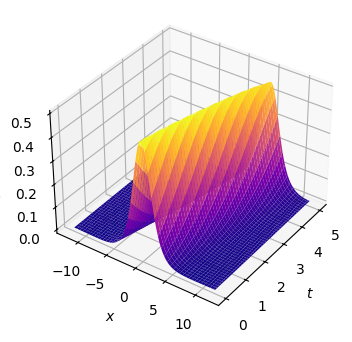

In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

tmin = tmin.cpu().item()
tmax = tmax.cpu().item()
xmin = xmin.cpu().item()
xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(6,4))
#fig.suptitle('Μοντελοποίηση ΜΔΕ Κύματος KdV με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')

ax1.invert_xaxis()


print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

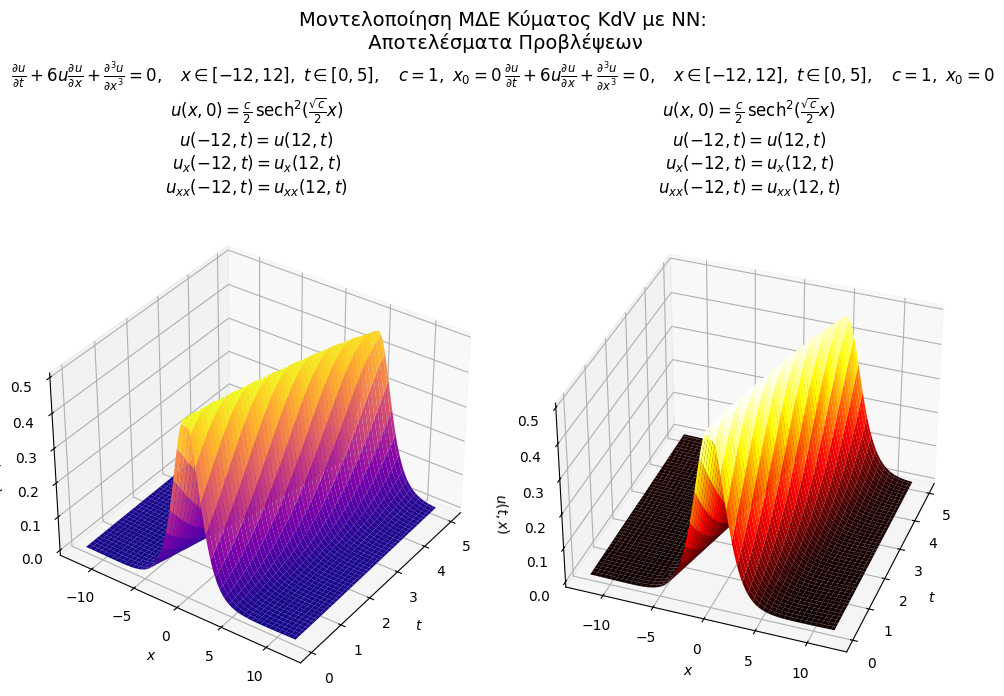

Για t=[0,T] έχουμε min U = -0.005, max U = 0.502
Στο t=Τ έχουμε min U = -0.005, max U = 0.459


In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(10,7))
fig.suptitle('Μοντελοποίηση ΜΔΕ Κύματος KdV με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')
ax1.set_title(r'$\frac{\partial u}{\partial t} + 6u \frac{\partial u}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0,\quad x \in [-12, 12],\ t \in [0,5], \quad c=1, \ x_0=0$' + '\n'
              r'$u(x, 0) = \frac{c}{2} \, \text{sech}^2 ( \frac{\sqrt{c}}{2} x )$' + '\n'
              r'$u(-12, t) = u(12, t)$' + '\n'
              r'$u_x(-12, t) = u_x(12, t)$' + '\n'
              r'$u_{xx}(-12, t) = u_{xx}(12, t)$' + '\n'
              ,fontsize=12);
ax1.invert_xaxis()

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T, X, U, cmap='hot');
ax2.view_init(35,20)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_zlabel('$u(t,x)$')
ax2.set_title(r'$\frac{\partial u}{\partial t} + 6u \frac{\partial u}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0,\quad x \in [-12, 12],\ t \in [0,5], \quad c=1, \ x_0=0$' + '\n'
              r'$u(x, 0) = \frac{c}{2} \, \text{sech}^2 ( \frac{\sqrt{c}}{2} x )$' + '\n'
              r'$u(-12, t) = u(12, t)$' + '\n'
              r'$u_x(-12, t) = u_x(12, t)$' + '\n'
              r'$u_{xx}(-12, t) = u_{xx}(12, t)$' + '\n'
              ,fontsize=12);
ax2.invert_xaxis()

# Εμφάνιση του αποτελέσματος
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

In [ ]:
import plotly.graph_objects as go

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#τίτλος
lines = (
    r'<b>Μοντελοποίηση ΜΔΕ Κύματος KdV με NN:<b>',
    r'$\frac{\partial u}{\partial t} + 6u \frac{\partial u}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0,\quad x \in [-12, 12],\ t \in [0,5], \quad c=1, \ x_0=0$',
    r'$u(x, 0) = \frac{c}{2} \, \text{sech}^2 ( \frac{\sqrt{c}}{2} x )$',
    r'$u(-12, t) = u(12, t)$',
    r'$u_x(-12, t) = u_x(12, t)$',
    r'$u_{xx}(-12, t) = u_{xx}(12, t)$'
)

#δημιουργία γραμμών τίτλου
annotations = []
x_pos = 0.05
start_y = 1.05
dy = -0.055

for i, line in enumerate(lines):
    annotations.append(
        dict(
          text=line,
          x=x_pos,
          y=start_y + i * dy,
          xref='paper',
          yref='paper',
          showarrow=False,
          font=dict(size=13 if i > 0 else 16, family="Arial"),
          align='center'
        )
    )

#αποκοπή των δεκαδικών ψηφίων από μιν μαξ τιμές για εμφάνιση
def truncation(x, decimals):
    factor = 10 ** decimals
    return torch.trunc(x * factor) / factor

U_tensor = torch.tensor(U)

min_U = truncation(torch.min(U_tensor), 3).item()
max_U = truncation(torch.max(U_tensor), 3).item()

#δημιουργία tickvals στη ράβδο
tickvals = [
    min_U + 0.001,
    truncation(torch.tensor((min_U + max_U)/2), 3).item(),
    max_U - 0.001
]

#δημιουργία 3D γραφήματος
fig = go.Figure(
    data=[
        go.Surface(
            x=tspace,
            y=xspace,
            z=U,
            colorscale='jet',
            colorbar=dict(
                title=dict(text='u(x,t)', side='top', font=dict(size=12)),
                tickvals = tickvals,
                x=0.88,         # αριστερά/δεξιά
                y=0.48,         # πάνω/κάτω
                len=0.9,        # πόσο "μακρύ" κάθετα
                thickness=20,   # πόσο "παχύ" οριζόντια
                tickfont=dict(size=10)
                )
            )
        ]
    )

fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),
    scene=dict(
        xaxis=dict(title='t', autorange='reversed'),  #αντιστροφή άξονα x
        yaxis_title='x',
        zaxis_title='u(t,x)'
    ),
    annotations=annotations
        )

fig.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

Output hidden; open in https://colab.research.google.com to view.

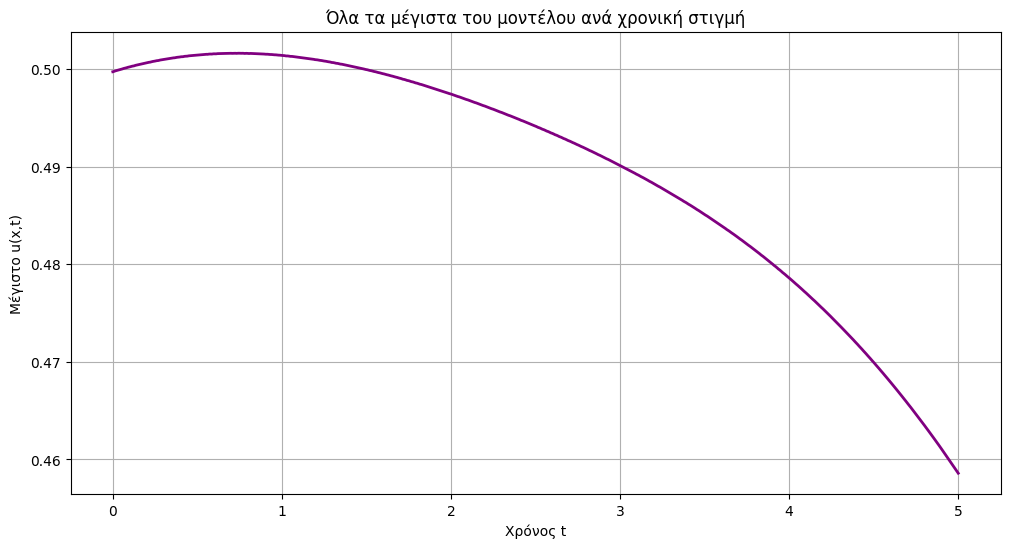

In [ ]:
#Πλήθος διαστημάτων
N = 1000

x = torch.linspace(L_min, L_max, N+1) #σημεία χώρου
t = torch.linspace(0, T_max, N+1) #σημεία χρόνου

#Δημιουργία πλέγματος (t,x)
T, X = torch.meshgrid(t, x, indexing='ij')

#Σχηματισμός tensor για το μοντέλο
X_eval = torch.cat([T.reshape(-1,1), X.reshape(-1,1)], dim=1)  # (Nt*Nx, 2)

#Πρόβλεψη μοντέλου
with torch.no_grad():
    U_pred = model(X_eval)  # (Nt*Nx,1)
    U_pred = U_pred.reshape(N+1, N+1)  # (Nt, Nx)

#Υπολογισμός μέγιστων σε κάθε χρόνο
u_max_list = torch.max(U_pred, dim=1)[0].cpu().numpy()  # (Nt,)

#Δημιουργία γραφήματος
fig = plt.figure(figsize=(12,6))
plt.plot(t.cpu().numpy(), u_max_list, 'purple', lw=2)
plt.xlabel('Χρόνος t')
plt.ylabel('Μέγιστο u(x,t)')
plt.title('Όλα τα μέγιστα του μοντέλου ανά χρονική στιγμή')
plt.grid(True)
plt.show()

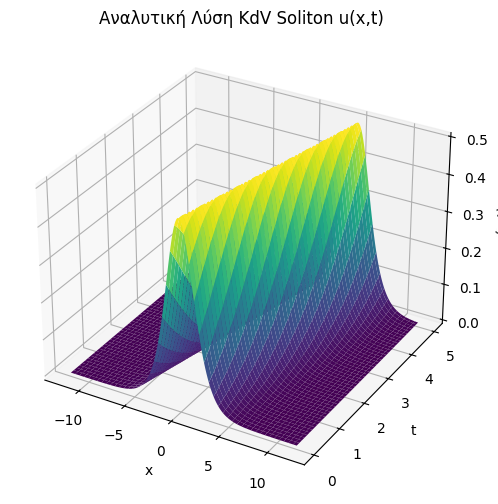

Μέγιστη τιμή Uanal = 0.5
Στο t=Τ έχουμε min Uanal = 0.000, max Uanal = 0.500


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Πεδίο
x = torch.linspace(L_min, L_max, 200)
t = torch.linspace(0, T_max, 200)
X, T = torch.meshgrid(x, t, indexing='ij')

#Αναλυτική Λύση soliton
U_anal = (c/2) * 1.0 / torch.cosh(torch.sqrt(c)/2 * (X - c*T))**2

#Γράφημα
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_anal, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Αναλυτική Λύση KdV Soliton u(x,t)')
plt.show()

#Μέγιστη τιμή Αναλυτικής Λύσης KdV
Uanal_max = torch.max(U_anal)
print("Μέγιστη τιμή Uanal =", Uanal_max.item())

# Τελικό χρονικό βήμα
Uanal_final = U_anal[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
Uanal_min = Uanal_final.min()
Uanal_max = Uanal_final.max()
print(f'Στο t=Τ έχουμε min Uanal = {Uanal_min:.3f}, max Uanal = {Uanal_max:.3f}')

Για c=1, L=12, zeta=3, Μέγιστος χρόνος: 6.0
Για c=1, L=6, zeta=3, Μέγιστος χρόνος: 3.0
Για c=5, L=12, zeta=3, Μέγιστος χρόνος: 1.863
Χρησιμοποιώντας c=1, L=12, zeta=3, έχουμε Μέγιστο χρόνο: 6.0


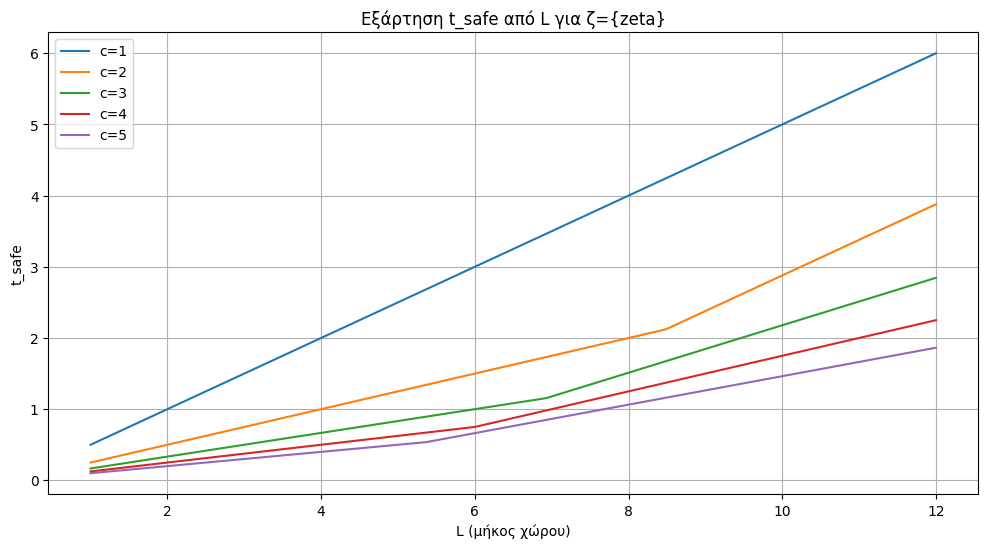

In [ ]:
#Εύρεση ασφαλούς μέγιστου χρόνου εξέλιξης κύματος KdV μέσα στο χωρικό πεδίο [-L,L]
#(εφαρμογή της συνθήκης CLF - Courant–Friedrichs–Lewy condition)

import math

def t_safe_periodic(c, L, zeta=3.0): #ζ = παράμετρος ασφαλείας, default 3.0
    delta = 2 * zeta / math.sqrt(c) #η ασφαλή απόσταση που αφαιρούμε από το μήκος του χώρου
    delta_eff = min(delta, L/2) #να μην ξεπεράσω το μισό μήκος του χώρου
    return max(0.0, (L - delta_eff) / c) #να μην πάρω αρνητικό χρόνο

print("Για c=1, L=12, zeta=3, Μέγιστος χρόνος:", round(t_safe_periodic(1,12,3),3) )
print("Για c=1, L=6, zeta=3, Μέγιστος χρόνος:", round(t_safe_periodic(1,6,3),3) )
print("Για c=5, L=12, zeta=3, Μέγιστος χρόνος:", round(t_safe_periodic(5,12,3),3) )

# Παράμετροι για plot
L_val = np.linspace(1, 12, 200) #μήκος χώρου
c_val = [1, 2, 3, 4, 5] # διαφορετικές τιμές c
zeta = 3.0 #ζ = παράμετρος ασφαλείας, default 3.0

fig = plt.figure(figsize=(12,6))

for c in c_val:
    t_safe_vals = [t_safe_periodic(c, L, zeta) for L in L_val]
    plt.plot(L_val, t_safe_vals, label=f'c={c}')

print(f"Χρησιμοποιώντας c={1}, L={12}, zeta={3}, έχουμε Μέγιστο χρόνο:", round(t_safe_periodic(1,12,3),3) )

plt.xlabel('L (μήκος χώρου)')
plt.ylabel('t_safe')
plt.title('Εξάρτηση t_safe από L για ζ={zeta}')
plt.legend()
plt.grid(True)
plt.show()

###Διαφορές προσεγγίσεων:

*1) Αναλυτική - Pinn*

*2) Αναλυτική - RK4*

*3) Pinn - RK4*

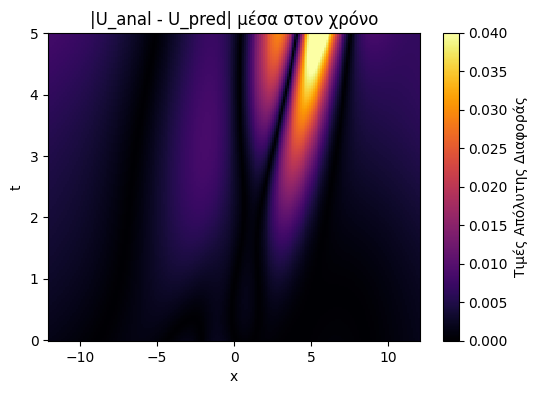

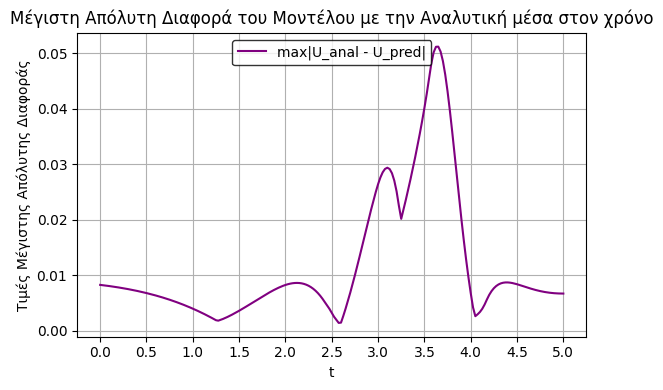

Στο t=Τ έχουμε min U_pred = -0.005, max U_pred = 0.458
Στο t=Τ έχουμε min U_anal = 0.000, max U_anal = 0.500


In [ ]:
#1)Απόλυτες και Μέγιστες Διαφορές του Μοντέλου με την Αναλυτική μέσα στον χρόνο

#dtype = torch.float32
c = torch.tensor(1, dtype=dtype)

N=200

#σημεία
x = torch.linspace(xmin, xmax, N+1)
t = torch.linspace(tmin, tmax, N+1)
X, T = torch.meshgrid(x, t)


#αναλυτική λύση κύματος
U_anal = (c/2) * 1.0 / torch.cosh(torch.sqrt(c)/2 * (X - c*T))**2

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
U_pred = upred.detach().numpy().reshape(N+1, N+1)
U_anal_np = U_anal.detach().cpu().numpy()

abs_diff = np.abs(U_pred - U_anal_np)   #απόλυτη διαφορά (Ν+1,Ν+1)
#mean_diff = np.mean(abs_diff, axis=1)   #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=1)     #μέγιστη τιμή διαφοράς (Ν+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.04

plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('|U_anal - U_pred| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_anal - U_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_anal - U_pred|', color='purple')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('Μέγιστη Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
U_final = U_pred[:,-1]  # τελευταία γραμμή
Uanal_final = U_anal_np[:,-1]

#Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U_pred = {U_min:.3f}, max U_pred = {U_max:.3f}')

Uanal_min = np.min(Uanal_final)
Uanal_max = np.max(Uanal_final)
print(f'Στο t=Τ έχουμε min U_anal = {Uanal_min:.3f}, max U_anal = {Uanal_max:.3f}')

In [ ]:
#ανέβασμα αρχείου Matlab

from google.colab import files
import os
import pandas as pd
import torch

filename = "u_kdv_p.csv"

print(os.listdir())  # εμφανίζει όλα τα αρχεία στον φάκελο

#ρωτάω για αντικατάσταση αρχείου
if os.path.exists(filename):
    answer = input(f"Θέλεις να διαγράψω το αρχείο '{filename}' ; (ναι/οχι): ").strip().lower()

    if answer == "ναι":
        os.remove(filename)
        print(f"Το αρχείο '{filename}' διαγράφηκε.")
    else:
        print("Η διαγραφή ακυρώθηκε.")
else:
    print(f"Το αρχείο '{filename}' δεν υπάρχει.")


if os.path.exists(filename):
    print(f"Το αρχείο '{filename}' υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    df = pd.read_csv(filename, header=None)
else:
    print(f"Το αρχείο '{filename}' ΔΕΝ υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    upload = files.upload()  # θα ανοίξει παράθυρο για να ανεβάσω το CSV
    upload_filename = list(upload.keys())[0]   # το όνομα του πρώτου αρχείου
    df = pd.read_csv(upload_filename, header=None)

# Μετατροπή σε tensor
U_RK4 = torch.tensor(df.values, dtype=dtype)

print("Μέγεθος u:", U_RK4.shape)


['.config', 'u_kdv_p.csv', 'sample_data']
Θέλεις να διαγράψω το αρχείο 'u_kdv_p.csv' ; (ναι/οχι): οχι
Η διαγραφή ακυρώθηκε.
Το αρχείο 'u_kdv_p.csv' υπάρχει στον τρέχοντα φάκελο (/content).
Μέγεθος u: torch.Size([124, 2501])


xmin=-12.0, xmax=12.0, Nx=124
tmin=0.0, tmax=5.0, Nt=2501
(124, 2501)
(124, 2501)


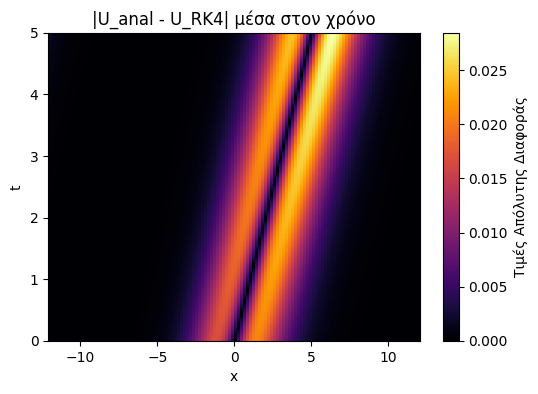

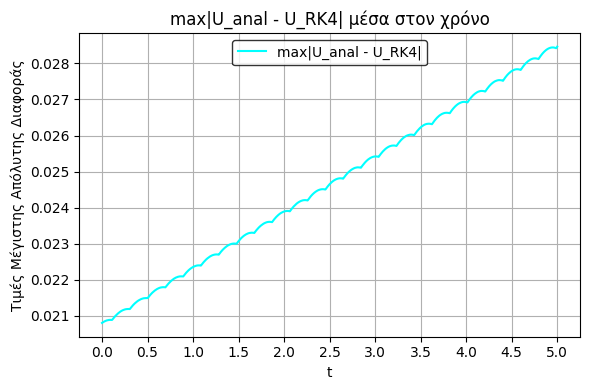

Στο t=Τ έχουμε min U = 0.000, max U = 0.500
Στο t=Τ έχουμε min U_RK4 = 0.000, max U_RK4 = 0.500


In [ ]:
#2)Διαφορές μεταξύ Μοντέλου και RK4 μέσα στον χρόνο
import numpy as np

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = U_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = torch.linspace(xmin, xmax, Nx)
t = torch.linspace(tmin, tmax, Nt)
X, T = torch.meshgrid(x, t)

print(f'xmin={xmin}, xmax={xmax}, Nx={Nx}')
print(f'tmin={tmin}, tmax={tmax}, Nt={Nt}')

#σταθερά
c = torch.tensor(1, dtype=dtype)

#αναλυτική λύση κύματος
U_anal = (c/2) * 1.0 / torch.cosh(torch.sqrt(c)/2 * (X - c*T))**2

#μετατροπή σε numpy
U_anal_np = U_anal.detach().cpu().numpy()
U_RK4_np  = U_RK4.detach().cpu().numpy()

print(U_anal_np.shape)
print(U_RK4_np.shape)

abs_diff = np.abs(U_anal_np.T - U_RK4_np.T) #απόλυτη διαφορά
#mean_diff = np.mean(abs_diff, axis=1)     #μέση τιμή διαφοράς
max_diff = np.max(abs_diff, axis=1)       #μέγιστη τιμή διαφοράς


#γραφήματα

#Πρώτο γράφημα: pcolormesh
plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff.T, shading='auto', cmap='inferno')
plt.title('|U_anal - U_RK4| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_anal - U_RK4|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά της Αναλυτικής με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_anal - U_RK4|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|U_anal - U_RK4| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
Uanal_final = U_anal_np[:,-1]  # τελευταία γραμμή
URK4_final = U_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
Uanal_min = np.min(Uanal_final)
Uanal_max = np.max(Uanal_final)
print(f'Στο t=Τ έχουμε min U = {Uanal_min:.3f}, max U = {Uanal_max:.3f}')

URK4_min = np.min(URK4_final)
URK4_max = np.max(URK4_final)
print(f'Στο t=Τ έχουμε min U_RK4 = {URK4_min:.3f}, max U_RK4 = {URK4_max:.3f}')

xmin=-12.0, xmax=12.0, Nx=124
tmin=0.0, tmax=5.0, Nt=2501
(2501, 124)
(124, 2501)


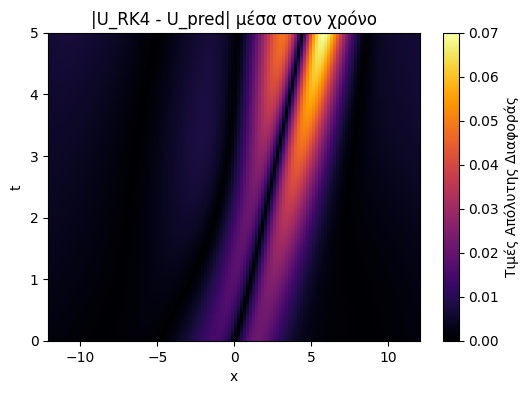

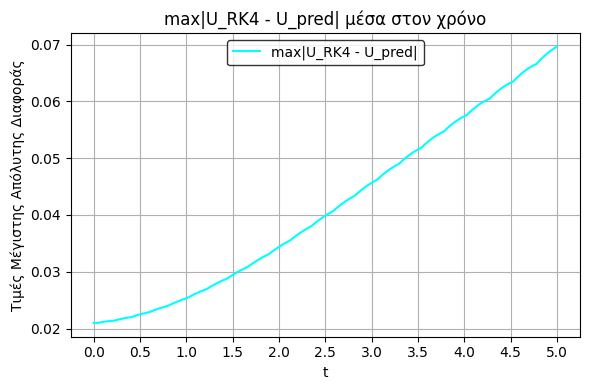

Στο t=Τ έχουμε min U_pred = -0.005, max U_pred = 0.458
Στο t=Τ έχουμε min U_RK4 = 0.000, max U_RK4 = 0.500


In [ ]:
#3)Διαφορές του Μοντέλου με την RK4 μέσα στον χρόνο

#dtype = torch.float32

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = U_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = np.linspace(xmin, xmax, Nx)
t = np.linspace(tmin, tmax, Nt)
X, T = np.meshgrid(x, t)

print(f'xmin={xmin}, xmax={xmax}, Nx={Nx}')
print(f'tmin={tmin}, tmax={tmax}, Nt={Nt}')

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
U_pred = upred.detach().numpy().reshape(Nt, Nx)
U_RK4_np  = U_RK4.detach().cpu().numpy()

print(U_pred.shape)
print(U_RK4_np.shape)

abs_diff = np.abs(U_pred - U_RK4_np.T) #απόλυτη διαφορά (Ν+1,Ν+1)
#mean_diff = np.mean(abs_diff, axis=1)      #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=1)        #μέγιστη τιμή διαφοράς (Ν+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.07

plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('|U_RK4 - U_pred| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_RK4 - U_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_RK4 - U_pred|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|U_RK4 - U_pred| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
U_final = U_pred[-1,:]  # τελευταία γραμμή
URK4_final = U_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U_pred = {U_min:.3f}, max U_pred = {U_max:.3f}')

URK4_min = np.min(URK4_final)
URK4_max = np.max(URK4_final)
print(f'Στο t=Τ έχουμε min U_RK4 = {URK4_min:.3f}, max U_RK4 = {URK4_max:.3f}')